In [11]:
import torch
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import json
from collections import Counter

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device.type}.")


# Load your dataset
text = open('C:/Users/raghu/CS6120_mywork_NLP/NLP_Ass3/archive2/text8').read().lower()

len(text)

Using cuda.


100000000

In [12]:
import torch

if torch.cuda.is_available():
    device_index = torch.cuda.current_device()
    total_memory = torch.cuda.get_device_properties(device_index).total_memory
    allocated_memory = torch.cuda.memory_allocated(device_index)
    free_memory = total_memory - allocated_memory

    print(f"Total GPU Memory: {total_memory / (1024 ** 3):.2f} GB")
    print(f"Allocated Memory: {allocated_memory / (1024 ** 3):.2f} GB")
    print(f"Free Memory: {free_memory / (1024 ** 3):.2f} GB")
else:
    print("CUDA is not available. Check your installation and GPU.")


Total GPU Memory: 8.00 GB
Allocated Memory: 0.05 GB
Free Memory: 7.95 GB


In [3]:
# # Tokenize and clean the dataset
# stop_wrods = stopwords.words('english')
# tokens = word_tokenize(text)
# tokens = [word.lower() for word in tokens if word.isalpha() and word not in stop_wrods]
# json_file_path = "C:/Users/raghu/CS6120_mywork_NLP/NLP_Ass3/tokens2.json"

# # Writing the tokens to the specified JSON file
# with open(json_file_path, "w") as json_file:
#     json.dump(tokens, json_file)

# json_file_path

In [13]:
json_file_path = "C:/Users/raghu/CS6120_mywork_NLP/NLP_Ass3/tokens2.json"

# Reading the tokens from the JSON file to build the vocabulary
with open(json_file_path, "r") as json_file:
    loaded_tokens = json.load(json_file)


# Build vocabulary
vocab = Counter(loaded_tokens)
vocab = [word for word, freq in vocab.most_common(20000)]
vocab_size = len(vocab)

In [14]:
len(loaded_tokens)

10888361

In [8]:
# # Function to generate context target pairs
# def generate_context_target_pairs(text, context_size):
#     data = []
#     for i in range(context_size, len(text) - context_size):
#         # Efficiently create context by concatenating two slices
#         context = text[i - context_size:i] + text[i + 1:i + context_size + 1]
#         target = text[i]
#         data.append((context, target))
#     return data


In [16]:
jpath_context_tar_pairs = "C:\\Users\\raghu\\CS6120_mywork_NLP\\NLP_Ass3\\context_target_pairs_2.json"

# Reading the tokens from the JSON file to build the vocabulary
with open(jpath_context_tar_pairs, "r") as json_file:
    load_context_target_pairs = json.load(json_file)


len(load_context_target_pairs), load_context_target_pairs[0]

(10888357, [['anarchism', 'originated', 'abuse', 'first'], 'term'])

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs):
        # inputs shape: [batch_size, context_size]
        embeds = self.embeddings(inputs)  # Shape: [batch_size, context_size, embedding_dim]
        avg_embeds = embeds.mean(dim=1)  # Average across context_size to get [batch_size, embedding_dim]
        out = self.linear(avg_embeds)  # Now: [batch_size, vocab_size]
        log_probs = torch.log_softmax(out, dim=1)
        return log_probs
    


class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, target_word):
        embeds = self.embeddings(target_word)
        out = self.linear(embeds)
        log_probs = torch.log_softmax(out, dim=1)
        return log_probs


In [19]:
word_to_index = {word: i for i, word in enumerate(vocab)}

def words_to_indices(tokens, word_to_index):
    return [word_to_index[word] for word in tokens if word in word_to_index]


In [20]:
# contex, target words converted to indices for CBOW
converted_training_data = []
for context, target in load_context_target_pairs:
    context_indices = words_to_indices(context, word_to_index)
    if target in word_to_index:  # Ensure the target word is also in the vocabulary
        target_index = word_to_index[target]
        converted_training_data.append((context_indices, target_index))


In [10]:
len(converted_training_data)

9898298

In [21]:
# contex, target words converted to indices for Skip_gram
converted_skip_training_data = []
for context, target in load_context_target_pairs:
    if target in word_to_index:  # Ensure the target word is also in the vocabulary
        target_index = word_to_index[target]
        # For Skip-gram, generate a pair for each context word
        for context_word in context:
            if context_word in word_to_index:  # Ensure the context word is also in the vocabulary
                context_index = word_to_index[context_word]
                # Append a pair of (target_index, context_index)
                converted_skip_training_data.append((target_index, context_index))

In [23]:
len(converted_skip_training_data)

36340176

In [24]:
from torch.utils.data import Dataset, DataLoader

class WordEmbeddingDataset(Dataset):
    def __init__(self, training_data):
        self.training_data = training_data

    def __len__(self):
        return len(self.training_data)

    def __getitem__(self, idx):
        context_indices, target_index = self.training_data[idx]
        return torch.tensor([context_indices], dtype=torch.long), torch.tensor([target_index], dtype=torch.long)


In [14]:
# vocab_size = len(vocab)  # Determine from your vocabulary
# embedding_dim = 100  # Choose a suitable embedding dimension
# model = CBOWModel(vocab_size, embedding_dim).to(device)
# loss_function = nn.NLLLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01)
# num_epochs = 5
# training_data = converted_training_data[:10000]
# # Filtering out empty arryys with 0 context words
# filtered_training_data = [item for item in training_data if len(item[0]) > 0]
# batch_size = 256  # Adjust based on your GPU memory
# dataset = WordEmbeddingDataset(filtered_training_data)  # Use your filtered training data here
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=6)

# for epoch in range(num_epochs):
#     total_loss = 0
#     for context_indices, target_index in data_loader:  # Batches are automatically provided by the DataLoader
#         context_indices = context_indices.to(device)
#         target_index = target_index.to(device)
#         model.zero_grad()
#         log_probs = model(context_indices)  # Your model might need adjustments to handle batched data
#         loss = loss_function(log_probs, target_index)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     print(f"Epoch {epoch}: Total Loss = {total_loss}")


In [25]:
vocab_size = len(vocab)  # Determine from your vocabulary
embedding_dim = 100  # Choose a suitable embedding dimension

model = CBOWModel(vocab_size, embedding_dim).to(device)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_epochs = 5
training_data = converted_training_data[:10000]
# Filtering out empty arryys with 0 context words
filtered_training_data = [item for item in training_data if len(item[0]) > 0]
# Training Loop
for epoch in range(num_epochs):

    total_loss = 0
    for context_indices, target_index in filtered_training_data:
        context_var = torch.tensor([context_indices], dtype=torch.long).to(device)
        target_var = torch.tensor([target_index], dtype=torch.long).to(device)
        model.zero_grad()
        log_probs = model(context_var)
        loss = loss_function(log_probs, target_var)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}: Total Loss = {total_loss}")


Epoch 0: Total Loss = 95086.29384549335
Epoch 1: Total Loss = 87746.39485730976
Epoch 2: Total Loss = 82503.27687167749
Epoch 3: Total Loss = 78018.20894682407
Epoch 4: Total Loss = 74000.58710891823


In [27]:
skip_model = SkipGramModel(vocab_size, embedding_dim).to(device)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(skip_model.parameters(), lr=0.01)
num_epochs = 5
training_data = converted_skip_training_data[:10000]
# Training Loop
for epoch in range(num_epochs):

    total_loss = 0
    for context_indices, target_index in training_data:
        context_var = torch.tensor([context_indices], dtype=torch.long).to(device)
        target_var = torch.tensor([target_index], dtype=torch.long).to(device)
        skip_model.zero_grad()
        log_probs = skip_model(context_var)
        loss = loss_function(log_probs, target_var)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}: Total Loss = {total_loss}")


Epoch 0: Total Loss = 116153.69325568635
Epoch 1: Total Loss = 82863.40459771757
Epoch 2: Total Loss = 75349.25774848455
Epoch 3: Total Loss = 70848.23209585721
Epoch 4: Total Loss = 68970.9664796457


In [28]:
import numpy as np
# Extarcting embedding from embedding layer's weights
cbow_word_embeddings = model.embeddings.weight.data.cpu().numpy()
skip_word_embeddings = skip_model.embeddings.weight.data.cpu().numpy()


# Saving the embeddings for later use
np.save('CBOW_word_embeddings.npy', cbow_word_embeddings)
np.save('SkipGram_word_embeddings.npy', skip_word_embeddings)

# To load these embeddings later
cbow_loaded_embeddings = np.load('CBOW_word_embeddings.npy')
skip_loaded_embeddings = np.load('SkipGram_word_embeddings.npy')

In [29]:
def get_embedding_for_word(word, word_to_index, embeddings):
    word_index = word_to_index.get(word)
    if word_index is not None:
        return embeddings[word_index]
    else:
        return None

# Example usage
word = 'went'
embedding = get_embedding_for_word(word, word_to_index, skip_loaded_embeddings)
print(f"Embedding for the word '{word}': {embedding}")


Embedding for the word 'went': [-0.4849971   0.9900263   0.37533402 -1.1048199  -0.4661441   0.46639892
  2.2026105  -0.46282822 -0.2982269  -0.66518694  1.2401046  -0.3922466
 -0.04353609 -0.96940583 -0.7604375   0.29433507  0.19989127  0.5695766
 -0.54126126  1.6028134   1.1367168  -0.68832123 -0.6204035  -2.7773607
  0.26772618 -0.7404348   0.8661951   0.69436723 -2.9839628  -0.6583806
 -1.0230813  -1.278414    0.34610072 -0.90456617  0.76559913  0.11184783
  2.8527741   1.1616607   0.29676363  2.135462   -1.0247191   0.09320427
  0.20412058  1.6326209   0.86534655  0.02084959  0.88593596  1.6382701
  0.99044883 -1.0412594   1.0151453  -0.88756675 -1.2942655   0.18906717
 -0.13625738 -0.6886316  -0.09496537 -0.7138599  -1.5489385  -0.7829199
  1.0052898   0.4860758  -0.11180492 -0.8936083   0.01594184  0.13704191
 -0.46484253  0.6508991   1.0760423  -0.6133793   1.1477555   1.1229591
 -0.95691013 -0.54820526 -0.57219136 -2.1135929   1.0900255   0.19808447
  0.45466608  0.5175789  -1

In [30]:
from numpy.linalg import norm

def cosine_similarity(vec_a, vec_b):
    """Compute the cosine similarity between two vectors."""
    return np.dot(vec_a, vec_b) / (norm(vec_a) * norm(vec_b))


In [31]:
# Assuming 'loaded_embeddings' is your array of word embeddings and 'word_to_index' is your word to index mapping

word_pairs = [
    ('king', 'queen'),
    ('man', 'woman'),
    ('paris', 'france'),
]

for word1, word2 in word_pairs:
    embedding1 = get_embedding_for_word(word1, word_to_index, cbow_loaded_embeddings)
    embedding2 = get_embedding_for_word(word2, word_to_index, cbow_loaded_embeddings)
    if embedding1 is not None and embedding2 is not None:
        similarity = cosine_similarity(embedding1, embedding2)
        print(f"Cosine similarity between '{word1}' and '{word2}': {similarity}")
    else:
        print(f"Word pair not found in vocabulary: '{word1}', '{word2}'")


Cosine similarity between 'king' and 'queen': 0.08031344413757324
Cosine similarity between 'man' and 'woman': -0.15724319219589233
Cosine similarity between 'paris' and 'france': 0.17142851650714874


In [32]:
for word1, word2 in word_pairs:
    embedding1 = get_embedding_for_word(word1, word_to_index, skip_loaded_embeddings)
    embedding2 = get_embedding_for_word(word2, word_to_index, skip_loaded_embeddings)
    if embedding1 is not None and embedding2 is not None:
        similarity = cosine_similarity(embedding1, embedding2)
        print(f"Cosine similarity between '{word1}' and '{word2}': {similarity}")
    else:
        print(f"Word pair not found in vocabulary: '{word1}', '{word2}'")


Cosine similarity between 'king' and 'queen': -0.014496013522148132
Cosine similarity between 'man' and 'woman': -0.061666931957006454
Cosine similarity between 'paris' and 'france': -0.030888674780726433


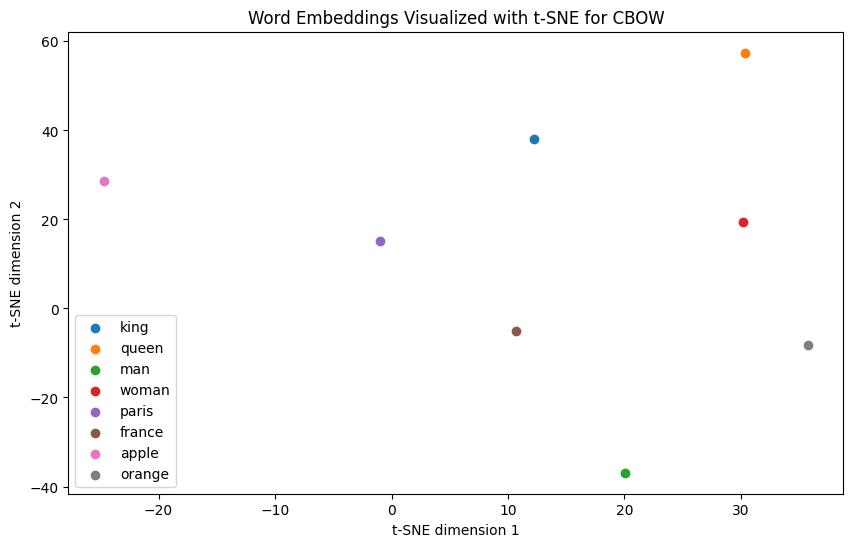

In [35]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Select a subset of word embeddings to visualize
words_to_visualize = ['king', 'queen', 'man', 'woman', 'paris', 'france', 'apple', 'orange']
indices_to_visualize = [word_to_index[word] for word in words_to_visualize if word in word_to_index]
embeddings_to_visualize = cbow_loaded_embeddings[indices_to_visualize]

# Calculate an appropriate perplexity value (less than the number of samples)
n_samples = embeddings_to_visualize.shape[0]
perplexity_value = max(5, n_samples / 3)  # Example adjustment, ensuring perplexity is less than n_samples

# Apply t-SNE with the adjusted perplexity
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
reduced_embeddings = tsne.fit_transform(embeddings_to_visualize)

# Plotting code remains the same
plt.figure(figsize=(10, 6))
for i, word in enumerate(words_to_visualize):
    if word in word_to_index:  # Check if word is actually in our selected subset
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label=word)

plt.legend()
plt.title('Word Embeddings Visualized with t-SNE for CBOW')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

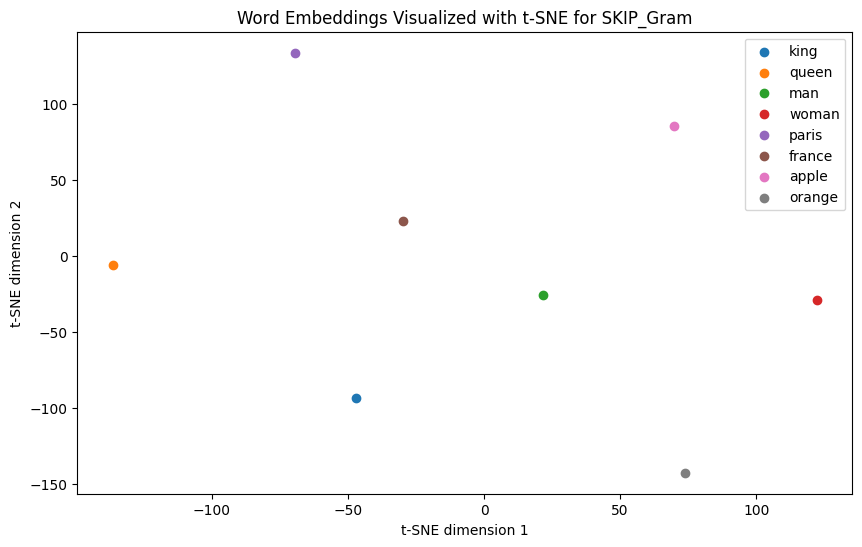

In [36]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Select a subset of word embeddings to visualize
words_to_visualize = ['king', 'queen', 'man', 'woman', 'paris', 'france', 'apple', 'orange']
indices_to_visualize = [word_to_index[word] for word in words_to_visualize if word in word_to_index]
embeddings_to_visualize = skip_loaded_embeddings[indices_to_visualize]

# Calculate an appropriate perplexity value (less than the number of samples)
n_samples = embeddings_to_visualize.shape[0]
perplexity_value = max(5, n_samples / 3)  # Example adjustment, ensuring perplexity is less than n_samples

# Apply t-SNE with the adjusted perplexity
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
reduced_embeddings = tsne.fit_transform(embeddings_to_visualize)

# Plotting code remains the same
plt.figure(figsize=(10, 6))
for i, word in enumerate(words_to_visualize):
    if word in word_to_index:  # Check if word is actually in our selected subset
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label=word)

plt.legend()
plt.title('Word Embeddings Visualized with t-SNE for SKIP_Gram')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

### Introduction to Word Embeddings, Skipgram, and CBOW

Word embeddings are dense vector representations of words in a continuous vector space where semantically similar words are mapped to proximate points. They capture syntactic and semantic word relationships based on the context of each word in a corpus. Skipgram and Continuous Bag of Words (CBOW) are two popular models for learning word embeddings, introduced by Mikolov et al. in the Word2Vec paper.

**Skipgram** aims to predict the context words for a given target word. It is particularly effective for learning high-quality representations for rare words.
  
- **CBOW**, in contrast, predicts a target word based on its context words. It is faster and slightly more accurate than Skipgram for frequent words.

### Architecture of the Models

Both models are implemented with a simple neural network architecture that includes an embedding layer and a linear layer.

- **CBOW Model**: The input to the CBOW model is the context words, which are averaged before being passed through a linear layer to predict the target word. 

- **Skipgram Model**: The Skipgram model takes a target word as input and passes it through a linear layer to predict its context words. 

Both models use the negative log likelihood loss function, with CBOW trained using Stochastic Gradient Descent (SGD) and Skipgram using the Adam optimizer.

### Dataset and Pre-processing Steps

The dataset used for training these models is a subset of the text8 dataset, which is a cleaned and pre-processed version of the first 100MB of the English Wikipedia dump. Pre-processing steps included:

- **Tokenization**: Splitting the text into individual words.
- **Stopword Removal**: Eliminating common words that add little semantic value.
- **Vocabulary Building**: Creating a list of unique words to form the vocabulary.
- **Index Mapping**: Assigning each unique word an index and converting words in the context-target pairs to their respective indices.

### Evaluation Results

Evaluation focused on intrinsic methods, examining the cosine similarity between vectors of selected word pairs like ('king', 'queen'), ('man', 'woman'), and ('Paris', 'France'). Visualizations using t-SNE highlighted clusters of semantically similar words, demonstrating the models' ability to capture meaningful linguistic patterns.

### Challenges and Potential Improvements

- **Sparse Data**: Some words had few context words, leading to challenges in training. Filtering out instances with insufficient context helped mitigate this issue.
  
- **Hyperparameter Tuning**: Finding the optimal set of hyperparameters (e.g., embedding dimension, window size) required extensive experimentation.

- **Computational Resources**: Training on large datasets demands significant computational resources. Training on subsets or using more efficient hardware could improve performance.

### Conclusion

The implemented CBOW and Skipgram models successfully learned meaningful word embeddings from the text8 dataset, demonstrating their capacity to capture semantic and syntactic word relationships. These embeddings have broad applications in natural language processing tasks, including sentiment analysis, named entity recognition, and machine translation. Future work could explore refining the models with larger datasets, implementing more sophisticated neural network architectures, and applying the embeddings to a wider range of NLP tasks. Potential improvements include exploring alternative optimization algorithms, experimenting with different architecture configurations, and incorporating subword information to better handle rare words.